# Summary

Starting point for a supervised learning model for Ookla speed tiles. The data comes from a combination of 
Ookla Open Data speed tests and Statistics Canada information, including 2016 census population data and census boundaries (shapefiles). 


In [1]:
import sys
sys.path.append("..")

In [2]:
import src.config

In [3]:
from src.datasets.loading import statcan, ookla

In [4]:
import numpy as np 
import pandas as pd
import geopandas as gp

In [5]:
from sklearn import preprocessing, pipeline, compose
from sklearn import linear_model, model_selection, svm
from sklearn import metrics

In [6]:
import matplotlib.pyplot as plt 

## Load 
Load some of the available data. The census population data and StatCan boundaries are automatically loaded from 
the StatCan website. The overlays and tile geometries/speeds need to pre-computed and saved to the overlays directory and data directories. 

### Load All Unique Tile Gemoetries

In [7]:
ookla_tiles = ookla.canada_tiles()

### Load Census Population Information

In [8]:
da_pops = statcan.dissemination_areas_populations()

/home/jovyan/src/datasets/loading/statcan.py:234: DtypeWarning: Columns (3,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(POP_FILE)


### Labelling Tiles
Generate labels from geometric overlay of the Ookla tiles and Statistics Canada Dissemination Areas (DA). 
Label each tile with the information from the StatCan areas based on which DA the tile overlaps the most with.

In [9]:
o = gp.read_file(src.config.OVERLAYS_DIR / 'tile_das_overlay') #this can take a few minutes to load.
tile_da_label = o.dropna(subset=['DAUID','quadkey']).sort_values(by=['quadkey','tile_frac'],ascending=False).drop_duplicates(subset='quadkey', keep='first')
tile_da_label['quadkey'] = tile_da_label['quadkey'].astype(int)
tile_da_label['DAUID'] = tile_da_label['DAUID'].astype(int)

### Speed Test Data
Load in the previous 4 quarters of data. Since we're currently in Q3 of 2022, the most recent quarter is Q2 
so we can slice the files listed to grab those. Subsequently, we'll calculate weighted averages for individual tiles and use those as representative speeds for our model.

In [10]:
last_4_quarters = ookla.speed_data(ookla.available_files().loc[('fixed',2021,3):('fixed',2022,2)].path)

In [11]:
down = last_4_quarters.groupby('quadkey').apply(lambda s:np.average(s.avg_d_kbps, weights=s.tests)).rename('avg_d_kbps')
up = last_4_quarters.groupby('quadkey').apply(lambda s:np.average(s.avg_u_kbps, weights=s.tests)).rename('avg_u_kbps')
tests = last_4_quarters.groupby('quadkey')['tests'].sum()
devices = last_4_quarters.groupby('quadkey')['devices'].sum()
last4_agg = pd.concat([down, up, tests, devices],axis=1)

### Merge All The Data
It's a bit messy, but we're merging several tables and removing a few of the redundant or non-useful 
columns as we go through. At the end the `features_table` variable will have all of the 
tiles within census areas labelled by what type of Census Subdivision, Dissemination Area, Population Centre, etc. they are in, as well as population information for the DA (smallest area with populations available) and the speed test averages over the last 4 quarters.

In [12]:
## merge dissemination area (DA) populations with ookla tiles (already combined with other statcan data)
features_table = tile_da_label.merge(da_pops, on='DAUID', how='left')
features_table['DAPOP'] = features_table['DAPOP'].fillna(0).astype(int)
del features_table['GEO_NAME']
features_table = pd.DataFrame(features_table)
del features_table['geometry']
features_table['POP_DENSITY'] = features_table['DAPOP']/features_table['das_area']*1000**2 #people per square kilometer

# take all ookla tiles, merge the speeds data and tile labels and populations
features_table = ookla_tiles.merge(last4_agg, on='quadkey').merge(features_table, on='quadkey')

# compute spatial joins to identify if area is a population centre
pop_info = statcan.boundary('population_centres').to_crs('epsg:4326')
pop_info = pop_info[['PCUID', 'PCNAME', 'PCTYPE', 'PCPUID', 'PCCLASS', 'geometry']] ##removes some redundant cols from DAs
features_table = features_table.sjoin(pop_info, how='left')
del features_table['index_right']
features_table = features_table.sort_values(by=['PCUID','quadkey']).drop_duplicates(subset=['quadkey']) #keep tiles where overlap was true

### Categorize All the Columns
All the columns from our joins above can be roughly split into categories based on the type of 
data and how you might use them in a simple supervised learning problem. These are broken down as follows:

In [13]:
pkey = 'quadkey'
geometry = 'geometry'
id_and_names = ['DAUID', 'CDUID', 'CDNAME', 'CCSUID', 'CSDNAME', 'CMAUID', 'CMAPUID', 'CMANAME', 
'CCSNAME', 'CSDUID', 'ERUID', 'ERNAME', 'CTUID', 'CTNAME', 'ADAUID', 
'PCUID', 'PCNAME', 'PCPUID', 'SACCODE',] ##SACCODE is half a category half ID values

categorical_labels = [
    #'PRUID', #PRUID is redundant with PRNAME
    'PRNAME', 'CDTYPE', 
    'CSDTYPE',  
    'SACTYPE', 
    'CMATYPE', 'PCTYPE', 'PCCLASS',
]
numerical_vars = [
    'tests', 'devices',
    'das_area', 'tile_area', 'tile_frac',  'das_frac', 
    'DAPOP','POP_DENSITY'
]
target_vars = ['avg_d_kbps', 'avg_u_kbps']

In [14]:
col_subset = [pkey] + categorical_labels + numerical_vars + target_vars
features_table.loc[:,col_subset].set_index('quadkey')

,PRNAME,CDTYPE,CSDTYPE,SACTYPE,CMATYPE,PCTYPE,PCCLASS,tests,devices,das_area,tile_area,tile_frac,das_frac,DAPOP,POP_DENSITY,avg_d_kbps,avg_u_kbps
quadkey,,,,,,,,,,,,,,,,,
302231302213222,Ontario,RM,T,1,B,2,2,12,8,4.489387e+06,205331.876525,0.917314,0.041955,1420,316.301553,201908.916667,23286.833333
302231302230013,Ontario,RM,T,1,B,2,2,32,7,5.391016e+06,205402.379648,0.894827,0.034094,1030,191.058601,393118.031250,169457.281250
302231302230022,Ontario,RM,T,1,B,2,2,4,2,1.030375e+07,205472.906899,0.611219,0.012189,505,49.011263,19284.750000,4310.750000
302231302230023,Ontario,RM,T,1,B,2,2,128,13,1.765704e+06,205472.906900,0.871430,0.101407,795,450.245236,10499.585938,1387.898438
302231302230030,Ontario,RM,T,1,B,2,2,1,1,5.391016e+06,205437.640257,0.939933,0.035818,1030,191.058601,535.000000,889.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303303002030011,Newfoundland and Labrador / Terre-Neuve-et-Lab...,CDR,T,5,NaN,NaN,NaN,1,1,1.777728e+07,179010.291685,0.579748,0.005838,350,19.688054,43155.000000,1901.000000
303303002032102,Newfoundland and Labrador / Terre-Neuve-et-Lab...,CDR,T,5,NaN,NaN,NaN,1,1,1.777728e+07,179287.191779,0.533632,0.005382,350,19.688054,1634.000000,690.000000
303303002122000,Newfoundland and Labrador / Terre-Neuve-et-Lab...,CDR,T,7,NaN,NaN,NaN,1,1,1.194131e+06,179256.404038,0.574792,0.086285,150,125.614323,37799.000000,12489.000000


## Train A Simple ML Model

In [15]:
#Standard train/test where down and/or up speeds are the target/predicted continuous variable.
X_train, X_test, \
down_train, down_test, \
up_train, up_test = model_selection.train_test_split(
    features_table, features_table['avg_d_kbps'], features_table['avg_u_kbps']
)

In [16]:
# Normalize the numerical Data and OneHot encode the categorical vars.
colTransformer = compose.ColumnTransformer(
    [(f"{cat}",preprocessing.OneHotEncoder(),[cat]) for cat in categorical_labels] \
    + [(f"{num}", preprocessing.StandardScaler(), [num]) for num in numerical_vars] 
    #+ [(f"{y}_stdscaler", preprocessing.StandardScaler(), [y]) for y in target_vars]
)

#Setup a regressor for predicting down/up speeds.
ridge = linear_model.RidgeCV()
regressor = compose.TransformedTargetRegressor(
    regressor=ridge,
    transformer=preprocessing.PowerTransformer(method='box-cox')
)

# Combine above in a reuseable pipeline object
pipe = pipeline.Pipeline([
    ('preprocess',colTransformer),
    ('regressor', regressor)
])

In [17]:
#train the model
pipe.fit(X_train, down_train);

### Look at Some Analytics
The performance isn't very good, specifically if we consider the context of 
determining if individuals can access internet at the Federal 50/10 Mbps commitment level.

In [18]:
# how did it do on the training set
# speeds are in kbps
{"Mean Absolute Error":metrics.mean_absolute_error(pipe.predict(X_train), down_train),
"Median Absolute Error":metrics.median_absolute_error(pipe.predict(X_train), down_train),
"Mean Absolute Percentage Error":metrics.mean_absolute_percentage_error(pipe.predict(X_train), down_train)}

{'Mean Absolute Error': 62376.67811732586,
 'Median Absolute Error': 33911.2445961363,
 'Mean Absolute Percentage Error': 1.0983110631529267}

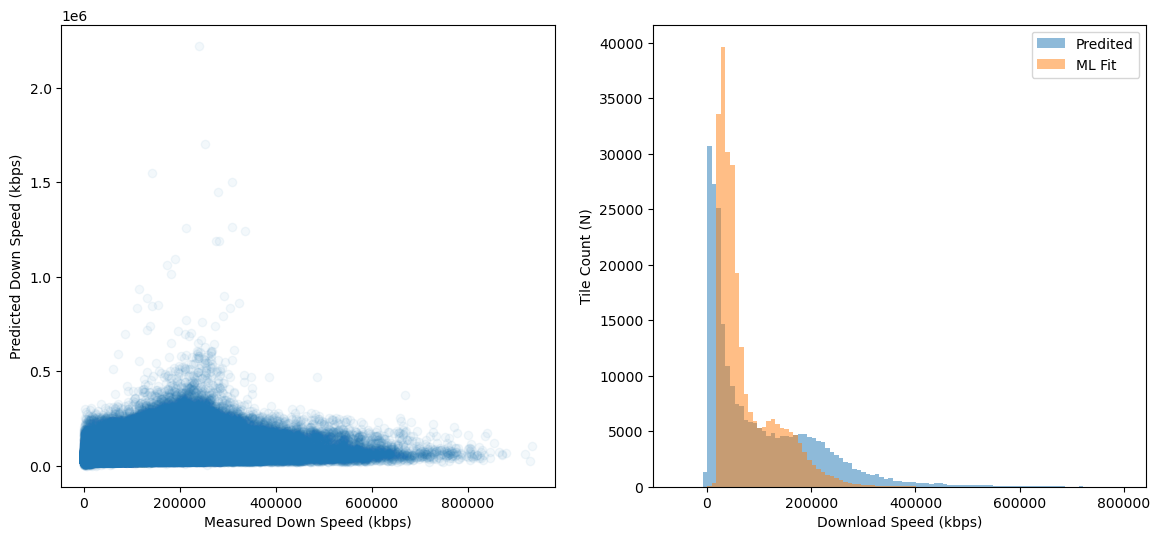

In [19]:
fig, axs = plt.subplots(1,2, figsize=(14,6))
axs[0].scatter(down_train, pipe.predict(X_train), alpha=0.05);
axs[0].set(xlabel="Measured Down Speed (kbps)", ylabel="Predicted Down Speed (kbps)");

bins = np.linspace(-60000,800000,100)
axs[1].hist(down_train,alpha=0.5, bins=bins,label='Predited')
axs[1].hist(pipe.predict(X_train),alpha=0.5, bins=bins,label='ML Fit');
axs[1].legend()
axs[1].set(xlabel='Download Speed (kbps)', ylabel='Tile Count (N)');

<Axes: >

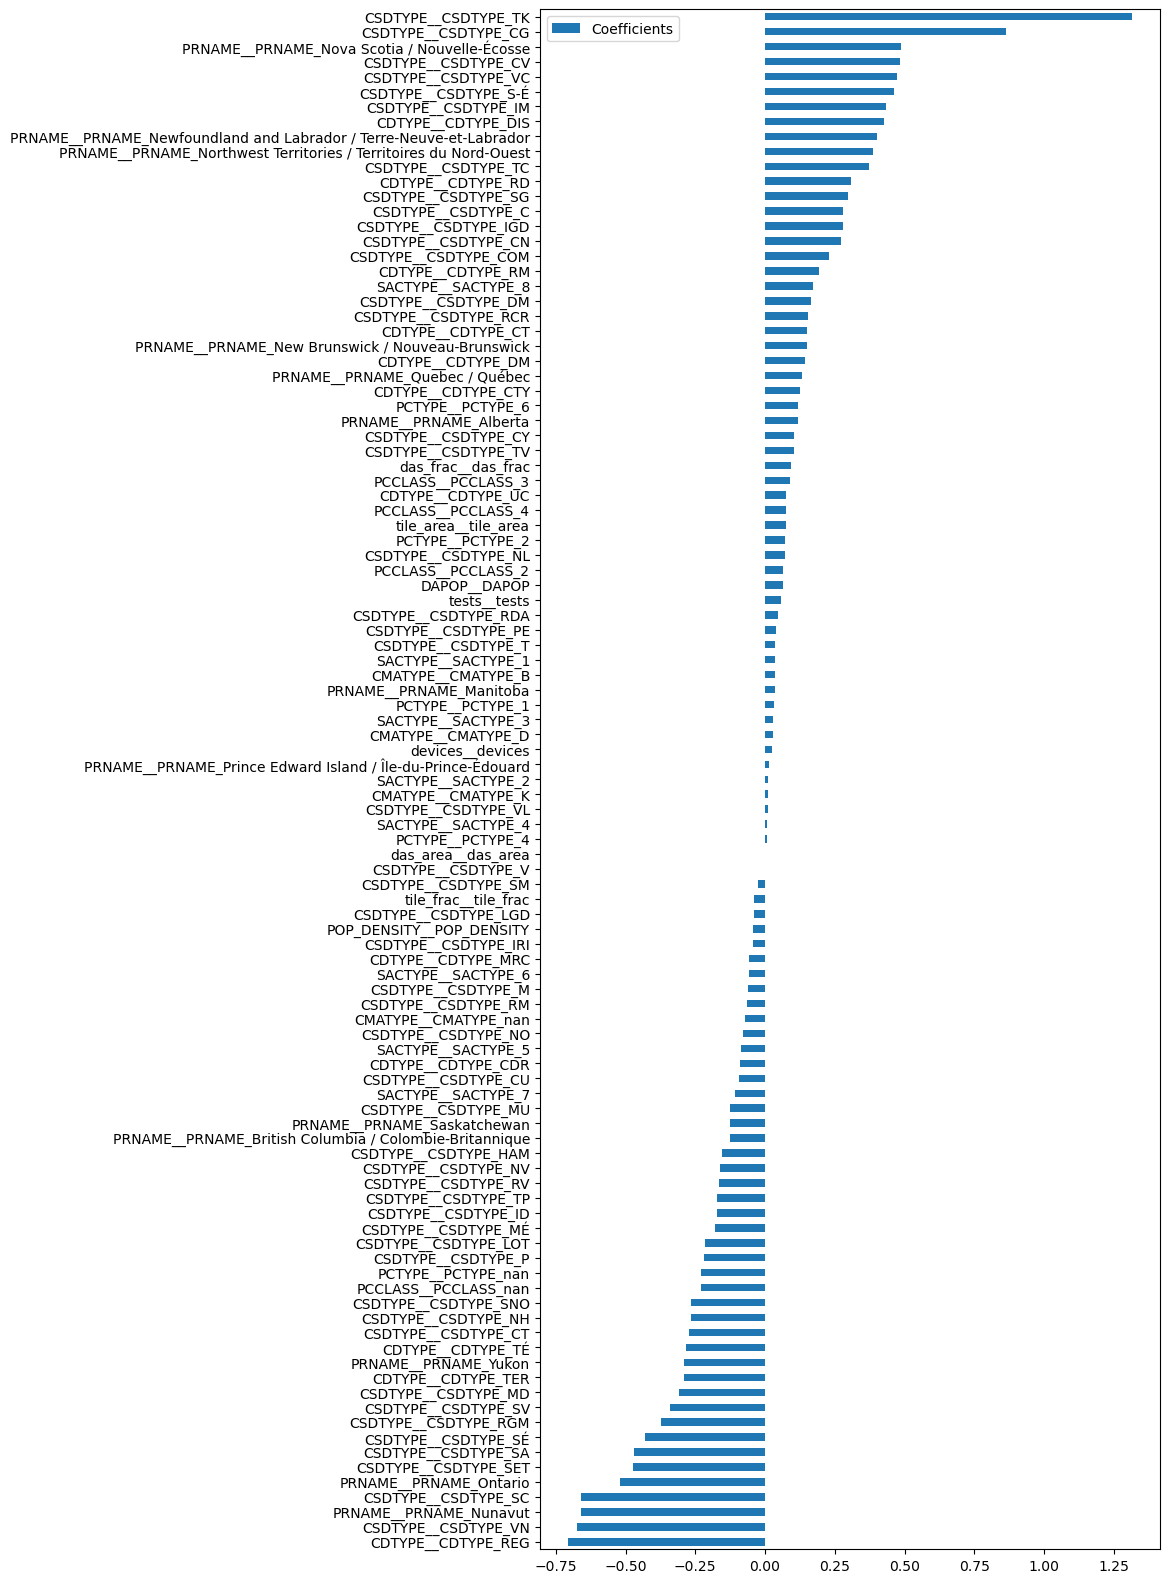

In [20]:
# What are the important coefficients.
coefs = pd.DataFrame(pipe[-1].regressor_.coef_,columns=['Coefficients'],index=pipe[:-1].get_feature_names_out())
coefs.sort_values(by='Coefficients').plot.barh(figsize=(8,20))